In [1]:
import tensorflow as tf

# 텐서플로 계산 그래프

In [ ]:
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')
z = 2*(a-b) + c  

In [ ]:
tf.print('결과: z = ', z)

결과: z =  1


In [ ]:
def compute(a, b, c):
  r1 = tf.subtract(a, b)
  r2 = tf.multiply(2, r1)
  z = tf.add(r2, r1)
  return z

In [ ]:
tf.print('스칼라 입력:', compute(1, 2, 3))
tf.print('스칼라 입력:', compute([1], [2], [3]))
tf.print('스칼라 입력:', compute([[1]], [[2]], [[3]]))

스칼라 입력: -3
스칼라 입력: [-3]
스칼라 입력: [[-3]]


# 텐서플로 변수 객체

In [ ]:
a = tf.Variable(initial_value=3.14, name='var_a')
print(a)

b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
print(b)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>


In [ ]:
# 훈련하지 않는 변수
w = tf.Variable([1, 2, 3], trainable=False)

In [ ]:
print(w.assign([3, 1, 4], read_value=True))

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4], dtype=int32)>


In [ ]:
w.assign_add([2, -1, 2], read_value=False) # Fasle : 업데이트된 값을 반환하지 않음

In [ ]:
print(w.value())

tf.Tensor([ 7 -1  8], shape=(3,), dtype=int32)


In [ ]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3, )))

[-0.722795904 1.01456821 0.251808226]


In [ ]:
v = tf.Variable(init(shape=(3, 3)))
tf.print(v)

[[0.264570385 -0.714132309 -0.0414132066]
 [0.877261102 -0.109547667 0.646794796]
 [-0.132300332 0.873413086 0.316882551]]


## tf.Module 클래스에 변수 정의

In [ ]:
class MyModule(tf.Module):
  def __init__(self):
    init = tf.keras.initializers.GlorotNormal()
    self.w1 = tf.Variable(init(shape=(2,3)), trainable=True)
    self.w2 = tf.Variable(init(shape=(1,2)), trainable=False)

In [ ]:
m = MyModule()

In [ ]:
print('모든 변수:', [v.shape for v in m.variables])
print('훈련 가능 변수:', [v.shape for v in m.trainable_variables])

모든 변수: [TensorShape([2, 3]), TensorShape([1, 2])]
훈련 가능 변수: [TensorShape([2, 3])]


## tf.function 데코레이터 적용된 함수 안에서 변수 사용

In [ ]:
w = tf.Variable(tf.random.uniform((3, 3)))
@tf.function
def compute(x):
  return tf.matmul(w, x)

In [ ]:
x = tf.constant([[1], [2], [3]], dtype=tf.float32)

In [ ]:
tf.print(compute(x))

[[2.93155909]
 [2.01902]
 [3.25393867]]


# 자동 미분과 그레이디언트 계산

$ z = wx + b $ : 예측 값     
$ \sum(y_i - z_i)^2 $ : 손실
* w, b : 파라미터 -> 변수
* x, y : 입력 -> 텐서

In [ ]:
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [ ]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])
with tf.GradientTape() as tape:
  z = tf.add(tf.multiply(w, x), b)
  loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw:', dloss_dw)

dL/dw: -0.559999764


## tape.watch() : 훈련가능하지 않은 변수에 대한 그레이디언트 계산

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(x)
  z = tf.add(tf.multiply(w, x), b)
  loss = tf.reduce_sum(tf.square(y - z))
dloss_dx = tape.gradient(loss, x)
tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


## persistent = True : 여러 개의 그레이디언트 계산

In [ ]:
with tf.GradientTape(persistent=True) as tape:
  z = tf.add(tf.multiply(w, x), b)
  loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)
tf.print('dL/dw:', dloss_dw,'\n dL/db:', dloss_db) 

dL/dw: -0.559999764 
 dL/db: -0.399999857


In [ ]:
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))
tf.print('업데이트 된 w:', w, '업데이트 된 b:', b)

업데이트 된 w: 1.0056 업데이트 된 b: 0.504


# 일반적인 구조

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 변수 출력
for v in model.variables:
  print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, 
                                activation=tf.keras.activations.relu, #활성화 함수
                                kernel_initializer=tf.keras.initializers.glorot_uniform(),  #층의 파라미터 초기화
                                bias_initializer=tf.keras.initializers.Constant(2.0)))
model.add(tf.keras.layers.Dense(units=16, 
                                activation=tf.keras.activations.sigmoid,
                                kernel_initializer=tf.keras.regularizers.l1))   #층의 파라미터 규제(과대적합 방지)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),  #경사하강법을 이용한 최적화, optimizer='sgd'
              loss=tf.keras.losses.BinaryCrossentropy(),    #이진분류 손실함수 
              metrics=[tf.keras.metrics.Accuracy(),   #정확도
                       tf.keras.metrics.Precision(),    #정밀도
                       tf.keras.metrics.Recall()])    #재현율

## XOR 문제

$ y^{(i)} = 0, \, x_0^{(i)} x_1^{(i)} < 0  \\ \, \, \, \, \, \, \, \, \, \, \, \, 1, \,\, o.w $

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

In [ ]:
x_train = x[:100, :]
y_train = y[:100]

In [ ]:
x_valid = x[100:, :]
y_valid = y[100:]

Text(0, 0.5, '$x_2$')

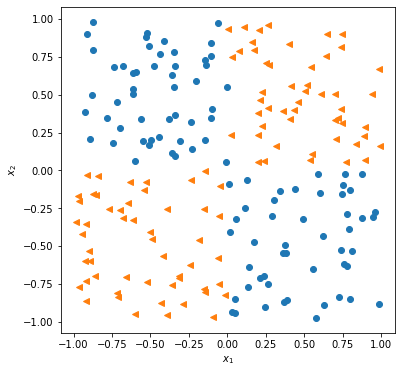

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o')
plt.plot(x[y==1, 0], x[y==1, 1], '<')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(2,), activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

<ipython-input-45-bf3c1ab10454>:14: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


10368/10368 [==============================] - 13s 1ms/step


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0, 0.5, '$x_2$')

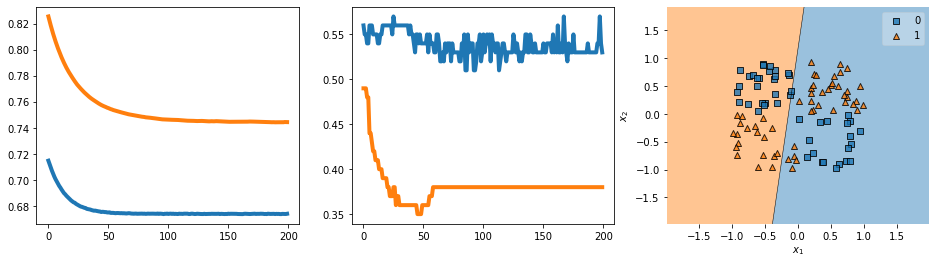

In [ ]:
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))
plt.xlabel('Epochs')
plt.subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)

plt.subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

   94/10368 [..............................] - ETA: 11s

<ipython-input-49-bf3c1ab10454>:14: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


10368/10368 [==============================] - 15s 1ms/step


Text(0, 0.5, '$x_2$')

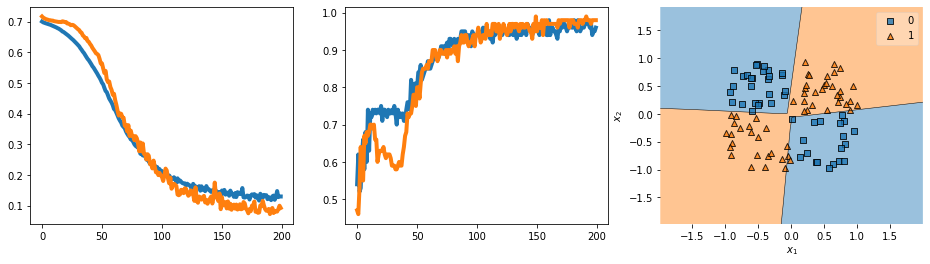

In [ ]:
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))
plt.xlabel('Epochs')
plt.subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)

plt.subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

## 케라스 함수형 API

In [ ]:
tf.random.set_seed(1)

In [ ]:
#입력층
inputs = tf.keras.Input(shape=(2, ))

In [ ]:
#은닉층
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

In [ ]:
#출력층
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 12        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## 케라스의 Model 클래스 기반

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
    self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
    self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
    self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

  def call(self, inputs):
    h = self.hidden_1(inputs)
    h = self.hidden_2(h)
    h = self.hidden_3(h)
    return self.output_layer(h)

In [ ]:
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            multiple                  12        
                                                                 
 dense_23 (Dense)            multiple                  20        
                                                                 
 dense_24 (Dense)            multiple                  20        
                                                                 
 dense_25 (Dense)            multiple                  5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## 사용자 정의 케라스 층

$ w(x + \epsilon ) +b $ 

In [ ]:
class NoisyLinear(tf.keras.layers.Layer):
  def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
    super(NoisyLinear, self).__init__(**kwargs)
    self.output_dim = output_dim
    self.noise_stddev = noise_stddev

  # 파라미터
  def build(self, input_shape):
    self.w = self.add_weight(name='weights',
                             shape=(input_shape[1], self.output_dim),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(name='bias',
                             shape=(self.output_dim, ),
                             initializer='zeros',
                             trainable=True)
  
  # 계산 결과
  def call(self, inputs, training=False):
    if training:
      batch = tf.shape(inputs)[0]
      dim = tf.shape(inputs)[1]
      noise = tf.random.normal(shape=(batch, dim), mean=0, stddev=self.noise_stddev)
      noisy_inputs = tf.add(inputs, noise)

    else:
      noisy_inputs = inputs
    
    z = tf.matmul(noisy_inputs, self.w) + self.b
    return z

  # 직렬화
  def get_config(self):
    config = super(NoisyLinear, self).get_config()
    config.update({'output_dim' : self.output_dim,
                     'noise_stddev' : self.noise_stddev})
    return config

In [ ]:
noise_layer = NoisyLinear(4)
noise_layer.build(input_shape=(None, 4))
x = tf.zeros(shape=(1, 4))

In [ ]:
x.numpy()

array([[0., 0., 0., 0.]], dtype=float32)

In [ ]:
tf.print(noise_layer(x, training=True))

[[0.00569171505 -0.0152384406 -0.0215303823 0.000575490762]]


In [ ]:
config = noise_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(noise_layer(x, training=True))

[[0.00479753315 -0.00678746 -0.00859160442 -0.000947017455]]


### 모델 생성

In [ ]:
tf.random.set_seed(1)

In [ ]:
model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1), 
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

In [ ]:
model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_linear_3 (NoisyLinear  (None, 4)                12        
 )                                                               
                                                                 
 dense_32 (Dense)            (None, 4)                 20        
                                                                 
 dense_33 (Dense)            (None, 4)                 20        
                                                                 
 dense_34 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

   44/10368 [..............................] - ETA: 12s  

<ipython-input-99-bf3c1ab10454>:14: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


10368/10368 [==============================] - 13s 1ms/step


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0, 0.5, '$x_2$')

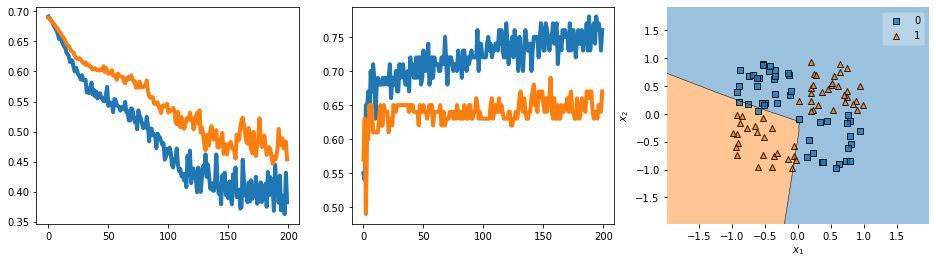

In [ ]:
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))
plt.xlabel('Epochs')
plt.subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)

plt.subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# 텐서플로 추정기

## 특성 열 사용
* 수치형 : 연속 or 이산
* 범주형

In [2]:
import pandas as pd

In [3]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       ("http://archive.ics.uci.edu/ml/machine-learning-databases"
                                        "/auto-mpg/auto-mpg.data"))

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'ModelYear', 'Origin']

30286/30286 [==============================] - 0s 4us/step


In [4]:
df = pd.read_csv(dataset_path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 전처리

In [5]:
# NA 삭제
df = df.dropna()
df = df.reset_index(drop=True)

In [6]:
# 훈련 테스트 셋 분할
import sklearn
from sklearn.model_selection import train_test_split

In [7]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [8]:
train_stats = df_train.describe().transpose()

In [9]:
numeric_col = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

In [10]:
df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

In [11]:
for col_name in numeric_col:
  mean = train_stats.loc[col_name, 'mean']
  std = train_stats.loc[col_name, 'std']
  df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
  df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std

In [12]:
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
328,33.8,-0.876490,-0.932613,-0.956853,-0.971305,0.849929,80,3
210,16.5,1.478371,1.481426,1.929293,1.641924,-1.263962,76,1
84,13.0,1.478371,1.481426,1.801587,1.314540,-0.941504,73,1
371,31.0,-0.876490,-0.989863,-0.931312,-1.175921,0.706614,82,3
134,16.0,1.478371,1.023427,0.907648,1.362478,-0.583217,74,1


### 특성 열 정의

In [13]:
# 텐서플로 추정기가 다루는 데이터 구조로 변환
# 연속형 특성
numeric_features = []
for col_name in numeric_col:
  numeric_features.append(tf.feature_column.numeric_column(key=col_name))

In [14]:
# 이산형 특성 -> model year 그룹으로 묶음
## 수치 특성으로 정의
feature_year = tf.feature_column.numeric_column(key='ModelYear')

## 분할 기준으로 정해 분할
bucketized_features = []
bucketized_features.append(tf.feature_column.bucketized_column(source_column=feature_year, boundaries=[73, 76, 79]))

In [15]:
# 범주형 특성
feature_orig = tf.feature_column.categorical_column_with_vocabulary_list(key='Origin', vocabulary_list=[1, 2, 3])

In [16]:
# 범주형 특성 -> 밀집 열로 변환
## 인디케이터 : 범주 인덱스를 원-핫 인코딩 벡터로 변환
categorical_indicator_features = []
categorical_indicator_features.append(tf.feature_column.indicator_column(feature_orig))

# 머신 러닝 수행

### 입력함수 정의

In [17]:
# 훈련 데이터를 위한 입력 함수
def train_input_fn(df_train, batch_size=8):
  df = df_train.copy()
  train_x, train_y = df, df.pop('MPG')
  dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))

  return dataset.shuffle(100).repeat().batch(batch_size)

In [18]:
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('Keys:', batch[0].keys())
print('ModelYear:', batch[0]['ModelYear'])

Keys: dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
ModelYear: tf.Tensor([80 70 73 80 71 73 81 73], shape=(8,), dtype=int64)


In [19]:
# 테스트 데이터를 위한 입력 함수
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y))

    return dataset.batch(batch_size)

### 데이터셋을 특성 열로 변환

In [20]:
# 연속, 이산, 범주 특성 열을 위한 리스트를 연결
all_feature_columns = (numeric_features + bucketized_features + categorical_indicator_features)

### 추정기 객체 생성

In [21]:
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='models/autompg-dnnregressor/')

### 추정기의 메서드 사용
* train
* evaluate
* predict

In [24]:
epochs = 100
batch_size = 8
total_steps = epochs * int(np.ceil(len(df_train) / batch_size))
print('훈련 스텝:', total_steps)

훈련 스텝: 4000


In [25]:
# 모델 훈련
regressor.train(input_fn=lambda:train_input_fn(df_train_norm, batch_size=batch_size),
                steps=total_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
reloaded_regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    warm_start_from='models/autompg-dnnregressor/',
    model_dir='models/autompg-dnnregressor/')

In [27]:
from importlib import reload
# 훈련된 모델의 예측 성능 평가
eval_results = reloaded_regressor.evaluate(input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

print('평균 손실 {:.4f}'.format(eval_results['average_loss']))

평균 손실 268.4515


# 케라스 모델에서 추정기 만들기

In [14]:
## 결과 재현을 위한 랜덤 시드
tf.random.set_seed(1)
np.random.seed(1)

## 데이터 생성
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

In [22]:
# 1단계 입력 함수를 정의
def train_input_fn(x_train, y_train, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices(
        ({'input-features':x_train}, y_train.reshape(-1, 1)))

    # 셔플, 반복, 배치
    return dataset.shuffle(100).repeat().batch(batch_size)

In [23]:
def eval_input_fn(x_test, y_test=None, batch_size=8):
    if y_test is None:
        dataset = tf.data.Dataset.from_tensor_slices(
            {'input-features':x_test})
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'input-features':x_test}, y_test.reshape(-1, 1)))


    # 셔플, 반복, 배치
    return dataset.batch(batch_size)

In [24]:
# 2단계 특성 열 정의
features = [
    tf.feature_column.numeric_column(
        key='input-features:', shape=(2,))
]
    
features

[NumericColumn(key='input-features:', shape=(2,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [25]:
# 3단계 추정기 변환(생성)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,), name='input-features'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 12        
                                                                 
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
 dense_14 (Dense)            (None, 4)                 20        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 3단계 추정기 변환
my_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir='models/estimator-for-XOR/')

In [27]:
# 4단계 추정기 사용
num_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(x_train) / batch_size)

my_estimator.train(
    input_fn=lambda: train_input_fn(x_train, y_train, batch_size),
    steps=num_epochs * steps_per_epoch)

Instructions for updating:
Use standard file utilities to get mtimes.


In [28]:
# 4단계 평가
my_estimator.evaluate(
    input_fn=lambda: eval_input_fn(x_valid, y_valid, batch_size))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


{'binary_accuracy': 0.97, 'loss': 0.06804774, 'global_step': 20000}